In [3]:
# tensorflow 2+
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

plt.style.use('dark_background')

# Load Models

In [4]:
facenet = cv2.dnn.readNet('models/deploy.prototxt', 'models/res10_300x300_ssd_iter_140000.caffemodel')
# Face Detection Model Load
model = load_model('models/mask_detector.model')
# Mask Detection Model Load

# Load Image

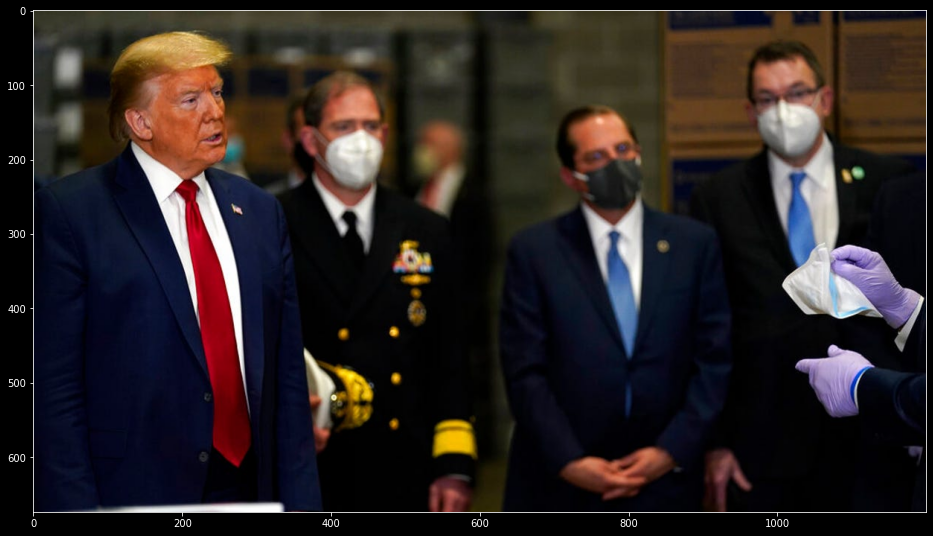

In [5]:
img = cv2.imread('imgs/01.jpg') # Test Image read
h , w = img.shape[:2] # image shape 높이, 너비 값 저장

plt.figure(figsize=(16, 10))
plt.imshow(img[:, :, ::-1]) # Opencv 로 읽게되면 BGR로 읽는데 이를 RGB로 변경하기 위한 코드


## Face Detection
먼저 얼굴 위치 검출 후 다시 마스크 착용 여부 판단

In [12]:
blob = cv2.dnn.blobFromImage(img, scalefactor=1., size=(300, 300), mean=(104., 177., 123.))
# blobFromImage를 통해서 dnn 모듈이 사용하는 형태로 이미지를 변형한다. axis순서만 바뀜
facenet.setInput(blob) # facenet의 input으로 설정
dets = facenet.forward() # 결과를 추론 -> Detection 결과가 dets에 저장

## Detect Faces

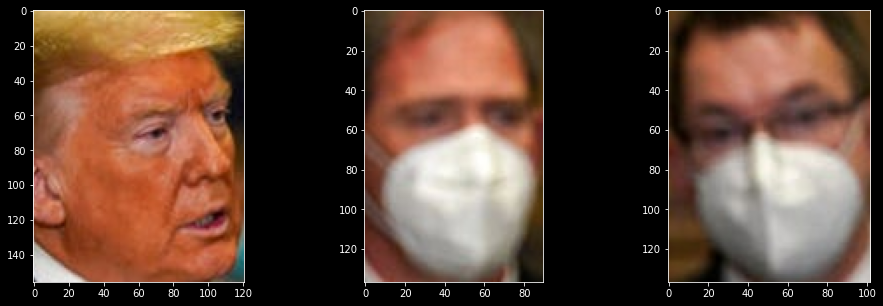

In [43]:
faces = []
for i in range(dets.shape[2]): # dets에 저장된 객체를 for문을 돌며 체크(여러개의 얼굴이 detection 될 수 있다)
    confidence = dets[0, 0, i, 2]
    if confidence < 0.4:
        continue
    x1 = int(dets[0, 0, i, 3] * w)
    y1 = int(dets[0, 0, i, 4] * h)
    x2 = int(dets[0, 0, i, 5] * w)
    y2 = int(dets[0, 0, i, 6] * h)
    # x와 y의 바운딩 박스 설정
    
    face = img[y1:y2, x1:x2] # 바운딩 박스에서 얼굴 부분만 잘라 낸다
    faces.append(face) # faces에 저장
    
    
plt.figure(figsize=(16, 5))

for i, face in enumerate(faces):
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:, :, ::-1])

## Detect Masks from Faces

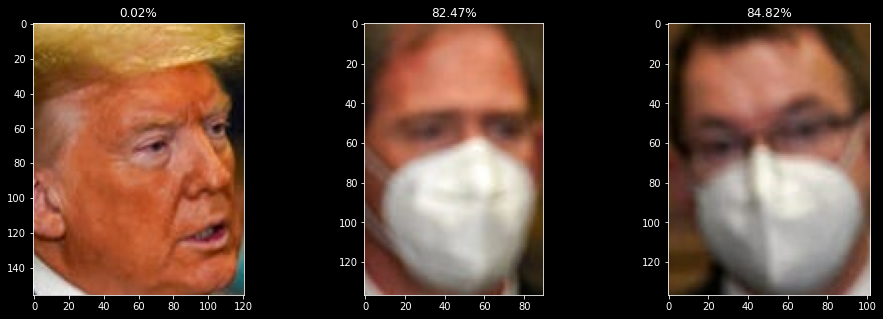

In [46]:
plt.figure(figsize=(16, 5))

for i, face in enumerate(faces):
    face_input = cv2.resize(face, dsize=(224, 224)) #resize 224,224
    face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB) #BGR을 RGB로 변경
    face_input = preprocess_input(face_input) # 모바일넷v2와 같이 preprocessing
    # 현재 상태 (224, 224, 3)
    # input 값에서는 (1, 224, 224, 3)의 형태로 넣어주여야 하므로 np.expand_dims()로 자원을 추가
    face_input = np.expand_dims(face_input, axis=0) 
    
    mask, nomask = model.predict(face_input).squeeze() # mask 쓴 확률 안쓴 확률 저장
    
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:, :, ::-1])
    plt.title('%.2f%%' % (mask * 100))
    